<a href="https://colab.research.google.com/github/DevKor-Team/MRDC-Challenge/blob/jo/jo/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
from __future__ import print_function
from __future__ import division

from PIL import Image

import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import albumentations
import albumentations.pytorch

In [3]:
BASE_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data'

import os

train = pd.read_csv(os.path.join(BASE_DIR, 'Train.csv'))
print(train.shape)
train.head()

(5340, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [4]:
train_rgb = train.loc[~train['Image_id'].str.contains('_rgn')]
train_rgb.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
2,id_005sitfgr2.jpg,brown
4,id_00stp9t6m6.jpg,blast
6,id_012zxewnhx.jpg,blast
8,id_0186qwq2at.jpg,healthy


In [5]:
test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))
test_rgb = test.loc[~test['Image_id'].str.contains('_rgn')]
test_rgb.head()

,Image_id
0,id_00vl5wvxq3.jpg
2,id_01hu05mtch.jpg
4,id_030ln10ewn.jpg
6,id_03z57m8xht.jpg
8,id_04ngep1w4b.jpg


In [6]:
ss = pd.read_csv(os.path.join(BASE_DIR, 'SampleSubmission.csv'))
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0


In [7]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs=5, early_stopping=None):
    model = model.to(device)

    dl = {'train': train_loader,
          'val': val_loader}
    
    val_label = []
    val_pred = []

    val_loss = 0.0
    for epoch in range(num_epochs):
        val_label = []
        val_pred = []

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients -> backward시 필요
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    # print(preds)
                    # print(labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'val':    # and epoch == num_epochs - 1:
                        val_label += labels.tolist()
                        val_pred += preds.tolist()
                        # print(val_label)

                # statistics
                running_loss += loss.item() * inputs.size(0)  # size(0) : batch size (첫 번째 차원 개수)
                                                              # item() : tensor에서 저장된 값만 가져오기
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dl[phase].dataset)  # 이렇게 나누면 epoch당 평균 loss가 됨
            epoch_acc = running_corrects.double() / len(dl[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            val_loss = epoch_loss

        if early_stopping != None:
          early_stopping(val_loss, model) # epoch_loss에는 validation loss가 저장
          if early_stopping.early_stop:
            print("Early stopping")
            break

    # load best model weights
    model.load_state_dict(torch.load(early_stopping.path))
    return model, val_label, val_pred

In [9]:
def test_model(device, model, test_loader):
    test_pred = []

    model.eval()
    model = model.to(device)
    with torch.set_grad_enabled(False):
        for features in test_loader:
            features = features.to(device)

            outputs = model(features.to(torch.float))
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            test_pred.append(probabilities.tolist())

    return test_pred

In [10]:
# confusion matrix 시각화
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names=None, labels=True):
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [11]:
class Img_Dataset_with_aug(Dataset):
    def __init__(self, file_path, aug_transform, table, is_train=True, test_transform=None):
        self.file_path = file_path
        self.aug_transform = aug_transform
        self.table = table
        self.is_train = is_train
        self.test_transform = test_transform
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []

        if self.is_train:   # train -> augmentation 필요
          self.table_label_list = self.table['Label'].tolist()
          self.label_list = []
          for i, img_name in enumerate(self.img_name_list):
            img = Image.open(os.path.join(self.file_path, img_name))
            if self.table_label_list[i] == 'blast':
              img_transformed = self.test_transform(image=np.array(img))['image']
              self.img_list.append(img_transformed)
              self.label_list.append(0)
            elif self.table_label_list[i] == 'brown':
              for _ in range(2):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(1)
            else:
              for _ in range(4):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(2)

        else:   # test -> augmentation 필요X
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.test_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
  
    def __len__(self):
        return len(self.img_list)
  
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

In [12]:
def make_data_loader_with_aug(batch_size=128, aug_transform=None, split=0.8):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  aug_transform=aug_transform
  test_transform=albumentations.Compose([
    albumentations.Resize(224, 224),
    # albumentations.Resize(256, 256),
    # albumentations.RandomCrop(224, 224),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensor(),
  ])

  # train data
  train_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, train_rgb, test_transform=test_transform)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, test_rgb, is_train=False, test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

# ResNet + Data Augmentation 다시

In [ ]:
class myResNet50(nn.Module):
  def __init__(self, num_classes):
    super(myResNet50, self).__init__()
    self.model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
aug_transform1=albumentations.Compose([
  # albumentations.Resize(256, 256),
  # albumentations.RandomCrop(224, 224),
  albumentations.Resize(224, 224),
  albumentations.OneOf([
                        albumentations.HorizontalFlip(p=1),
                        albumentations.RandomRotate90(p=1),
                        albumentations.VerticalFlip(p=1)            
  ], p=0.5),
  albumentations.Normalize(),
  albumentations.pytorch.ToTensor(),
])

In [ ]:
resnet50_tf = myResNet50(3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=128, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnet50_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnet50-aug8_checkpoint.pt"))

In [ ]:
train_rgb['Label'].value_counts()

blast      1494
brown       766
healthy     410
Name: Label, dtype: int64

In [ ]:
len(train_loader.dataset) + len(val_loader.dataset)

4666

In [ ]:
1494 + 766 * 2 + 410 * 4

4666

In [ ]:
resnet50_tf, val_label, val_pred = train_model(device, resnet50_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.5697 Acc: 0.7816
val Loss: 0.4295 Acc: 0.8394
Validation loss decreased (inf --> 0.429475).  Saving model ...
Epoch 2/30
----------
train Loss: 0.1088 Acc: 0.9668
val Loss: 0.2110 Acc: 0.9293
Validation loss decreased (0.429475 --> 0.210989).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0292 Acc: 0.9933
val Loss: 0.1876 Acc: 0.9315
Validation loss decreased (0.210989 --> 0.187626).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0138 Acc: 0.9971
val Loss: 0.1614 Acc: 0.9529
Validation loss decreased (0.187626 --> 0.161441).  Saving model ...
Epoch 5/30
----------
train Loss: 0.0340 Acc: 0.9898
val Loss: 0.1673 Acc: 0.9486
EarlyStopping counter: 1 out of 3
Epoch 6/30
----------
train Loss: 0.0260 Acc: 0.9906
val Loss: 0.1769 Acc: 0.9422
EarlyStopping counter: 2 out of 3
Epoch 7/30
----------
train Loss: 0.0230 Acc: 0.9936
val Loss: 0.1551 Acc: 0.9561
Validation loss decreased (0.161441 --> 0.155082).  Saving model ...
Epoch 8/30
-------

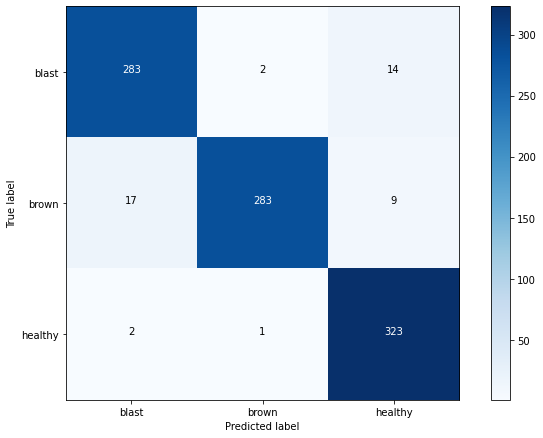

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, resnet50_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnet50_aug8.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999849,0.000101,0.000050
1,id_01hu05mtch.jpg,0.000760,0.999181,0.000058
2,id_030ln10ewn.jpg,0.254714,0.015420,0.729866
3,id_03z57m8xht.jpg,0.999910,0.000047,0.000043
4,id_04ngep1w4b.jpg,0.947240,0.049157,0.003603


augmentation 바꾸기 전 score : 0.55   
바꾼 후 score : 0.33   
또 바꿨더니 score : 0.25 (SOTA)

# ResNeXt

In [ ]:
class myResNeXt50(nn.Module):
  def __init__(self, num_classes):
    super(myResNeXt50, self).__init__()
    self.model_ft = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
resnext50_tf = myResNeXt50(3)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
# train
# train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=128, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnext50_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnext50-aug_checkpoint.pt"))

In [ ]:
resnext50_tf, val_label, val_pred = train_model(device, resnext50_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.5403 Acc: 0.7926
val Loss: 0.2556 Acc: 0.9176
Validation loss decreased (inf --> 0.255619).  Saving model ...
Epoch 2/30
----------
train Loss: 0.0591 Acc: 0.9850
val Loss: 0.1375 Acc: 0.9582
Validation loss decreased (0.255619 --> 0.137467).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0152 Acc: 0.9957
val Loss: 0.1479 Acc: 0.9518
EarlyStopping counter: 1 out of 3
Epoch 4/30
----------
train Loss: 0.0190 Acc: 0.9949
val Loss: 0.1249 Acc: 0.9582
Validation loss decreased (0.137467 --> 0.124909).  Saving model ...
Epoch 5/30
----------
train Loss: 0.0121 Acc: 0.9979
val Loss: 0.1885 Acc: 0.9518
EarlyStopping counter: 1 out of 3
Epoch 6/30
----------
train Loss: 0.0065 Acc: 0.9992
val Loss: 0.1363 Acc: 0.9657
EarlyStopping counter: 2 out of 3
Epoch 7/30
----------
train Loss: 0.0059 Acc: 0.9987
val Loss: 0.1434 Acc: 0.9668
EarlyStopping counter: 3 out of 3
Early stopping


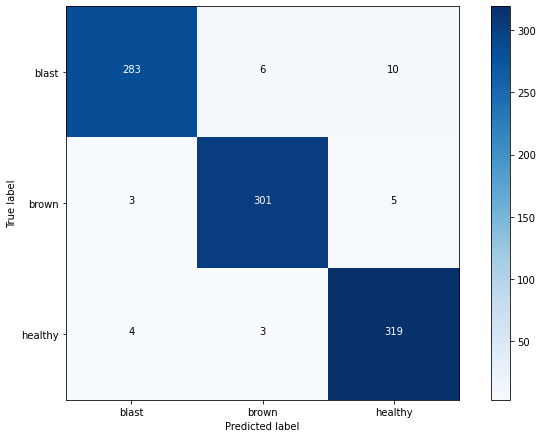

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, resnext50_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnext50_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999983,0.000012,0.000005
1,id_01hu05mtch.jpg,0.011584,0.985727,0.002689
2,id_030ln10ewn.jpg,0.088887,0.009966,0.901146
3,id_03z57m8xht.jpg,0.999917,0.000076,0.000007
4,id_04ngep1w4b.jpg,0.999383,0.000223,0.000394


score : 0.2 (SOTA!!)

# DeiT

In [ ]:
!pip install timm requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.3 MB/s 


In [ ]:
class myDeiT(nn.Module):
    def __init__(self, num_classes):
        super(myDeiT, self).__init__()
        self.model_ft = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        
        num_ftrs = self.model_ft.head.in_features
        self.model_ft.head = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        out = self.model_ft(x)
        return out

In [ ]:
deit_tf = myDeiT(3)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_384-8de9b5d1.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
# train
# train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=50, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(deit_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "deit-aug_checkpoint.pt"))

In [ ]:
deit_tf, val_label, val_pred = train_model(device, deit_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------


AssertionError: ignored

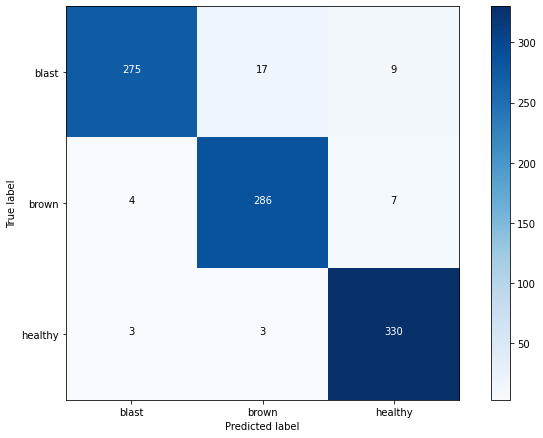

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, deit_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_deit_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999950,0.000038,0.000011
1,id_01hu05mtch.jpg,0.000216,0.998904,0.000880
2,id_030ln10ewn.jpg,0.999526,0.000331,0.000143
3,id_03z57m8xht.jpg,0.999971,0.000022,0.000008
4,id_04ngep1w4b.jpg,0.969252,0.029046,0.001701


deit_base_patch16_224 : score - 0.30

# DeiT_base_patch16_384

In [ ]:
aug_transform2=albumentations.Compose([
  albumentations.Resize(384, 384),
  albumentations.OneOf([
                        albumentations.HorizontalFlip(p=1),
                        albumentations.RandomRotate90(p=1),
                        albumentations.VerticalFlip(p=1)            
  ], p=0.5),
  albumentations.Normalize(),
  albumentations.pytorch.ToTensor(),
])

In [ ]:
def make_data_loader_with_aug2(batch_size=128, aug_transform=None, split=0.8):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  aug_transform=aug_transform
  test_transform=albumentations.Compose([
    albumentations.Resize(384, 384),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensor(),
  ])

  # train data
  train_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, train_rgb, test_transform=test_transform)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, test_rgb, is_train=False, test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [ ]:
class myDeiT(nn.Module):
    def __init__(self, num_classes):
        super(myDeiT, self).__init__()
        self.model_ft = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_384', pretrained=True)
        
        num_ftrs = self.model_ft.head.in_features
        self.model_ft.head = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        out = self.model_ft(x)
        return out

In [ ]:
deit_tf2 = myDeiT(3)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_384-8de9b5d1.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_384-8de9b5d1.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug2(batch_size=32, aug_transform=aug_transform2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: ignored

In [ ]:
optimizer = optim.Adam(deit_tf2.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "deit384-aug_checkpoint.pt"))

In [ ]:
deit_tf2, val_label, val_pred = train_model(device, deit_tf2, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------


RuntimeError: ignored

포기..^^

# mobileNetv3

In [ ]:
#@title
m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
print(m)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
class myMobileNetv3(nn.Module):
  def __init__(self, num_classes):
    super(myMobileNetv3, self).__init__()
    # self.model_ft = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
    self.model_ft = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.classifier[3].in_features
    self.model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
mobilenet_tf = myMobileNetv3(3)

In [ ]:
# train
# train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=128, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(mobilenet_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "mobilenet-aug_checkpoint.pt"))

In [ ]:
mobilenet_tf, val_label, val_pred = train_model(device, mobilenet_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.7314 Acc: 0.6731
val Loss: 0.8728 Acc: 0.6296
Validation loss decreased (inf --> 0.872815).  Saving model ...
Epoch 2/30
----------
train Loss: 0.2905 Acc: 0.8958
val Loss: 0.6242 Acc: 0.7645
Validation loss decreased (0.872815 --> 0.624165).  Saving model ...
Epoch 3/30
----------
train Loss: 0.1229 Acc: 0.9617
val Loss: 0.3488 Acc: 0.8683
Validation loss decreased (0.624165 --> 0.348756).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0445 Acc: 0.9885
val Loss: 0.2937 Acc: 0.9026
Validation loss decreased (0.348756 --> 0.293658).  Saving model ...
Epoch 5/30
----------
train Loss: 0.0189 Acc: 0.9957
val Loss: 0.2042 Acc: 0.9293
Validation loss decreased (0.293658 --> 0.204222).  Saving model ...
Epoch 6/30
----------
train Loss: 0.0181 Acc: 0.9946
val Loss: 0.1962 Acc: 0.9400
Validation loss decreased (0.204222 --> 0.196202).  Saving model ...
Epoch 7/30
----------
train Loss: 0.0082 Acc: 0.9984
val Loss: 0.1599 Acc: 0.9497
Validation loss d

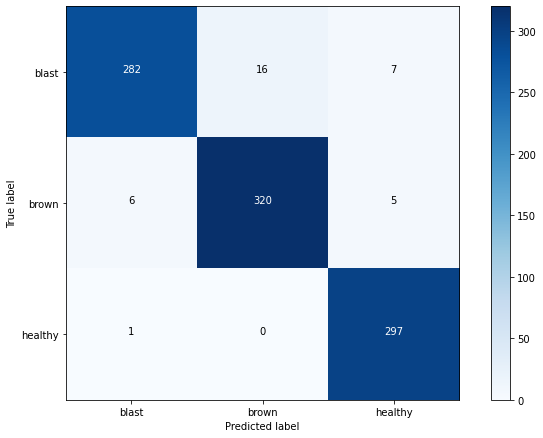

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, mobilenet_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_mobilenet_small_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999822,0.000127,0.000052
1,id_01hu05mtch.jpg,0.026630,0.956452,0.016918
2,id_030ln10ewn.jpg,0.000731,0.999033,0.000236
3,id_03z57m8xht.jpg,0.999994,0.000002,0.000004
4,id_04ngep1w4b.jpg,0.653044,0.281004,0.065953


large : 0.41
small : 0.35

# EfficientNet

In [ ]:
class myEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(myEfficientNet, self).__init__()
        self.model_ft = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)
        
        num_ftrs = self.model_ft.classifier.fc.in_features
        self.model_ft.classifier.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        out = self.model_ft(x)
        return out

In [ ]:
efficientnet_tf = myEfficientNet(3)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: p

  0%|          | 0.00/134M [00:00<?, ?B/s]

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=50, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(efficientnet_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "efficientnet-aug_checkpoint.pt"))

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
efficientnet_tf, val_label, val_pred = train_model(device, efficientnet_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.5581 Acc: 0.7824
val Loss: 0.3399 Acc: 0.8876
Validation loss decreased (inf --> 0.339853).  Saving model ...
Epoch 2/30
----------
train Loss: 0.0694 Acc: 0.9796
val Loss: 0.2433 Acc: 0.9240
Validation loss decreased (0.339853 --> 0.243299).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0194 Acc: 0.9957
val Loss: 0.2520 Acc: 0.9347
EarlyStopping counter: 1 out of 3
Epoch 4/30
----------
train Loss: 0.0268 Acc: 0.9914
val Loss: 0.1972 Acc: 0.9422
Validation loss decreased (0.243299 --> 0.197239).  Saving model ...
Epoch 5/30
----------
train Loss: 0.0252 Acc: 0.9925
val Loss: 0.1824 Acc: 0.9497
Validation loss decreased (0.197239 --> 0.182365).  Saving model ...
Epoch 6/30
----------
train Loss: 0.0217 Acc: 0.9936
val Loss: 0.1557 Acc: 0.9540
Validation loss decreased (0.182365 --> 0.155711).  Saving model ...
Epoch 7/30
----------
train Loss: 0.0222 Acc: 0.9922
val Loss: 0.1704 Acc: 0.9561
EarlyStopping counter: 1 out of 3
Epoch 8/30
-------

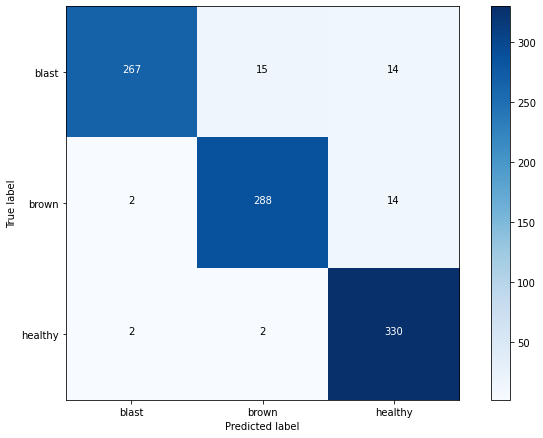

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, efficientnet_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_efficientnet_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999881,0.000083,3.571767e-05
1,id_01hu05mtch.jpg,0.001345,0.997780,8.751198e-04
2,id_030ln10ewn.jpg,0.012278,0.012060,9.756613e-01
3,id_03z57m8xht.jpg,0.999998,0.000001,8.150939e-07
4,id_04ngep1w4b.jpg,0.948576,0.049621,1.802326e-03


score : 0.32

Validation data에는 Augmentation 적용되지 않도록 data set 수정

In [ ]:
split_num = [i % 20 for i in range(len(train_rgb))]
train_rgb.loc[:, ['split_num']] = split_num
print(train_rgb.shape)
train_rgb.head(10)

(2670, 3)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Image_id,Label,split_num
0,id_004wknd7qd.jpg,blast,0
2,id_005sitfgr2.jpg,brown,1
4,id_00stp9t6m6.jpg,blast,2
6,id_012zxewnhx.jpg,blast,3
8,id_0186qwq2at.jpg,healthy,4
10,id_01vb9vty05.jpg,brown,5
12,id_01z6i8am9b.jpg,blast,6
14,id_02lw7skww5.jpg,blast,7
16,id_02olqz4tf5.jpg,blast,8
18,id_03878to61t.jpg,brown,9


In [ ]:
class Img_Dataset_with_aug(Dataset):
    def __init__(self, file_path, aug_transform, table, is_train='Train', test_transform=None):
        self.file_path = file_path
        self.aug_transform = aug_transform
        self.table = table
        self.is_train = is_train
        self.test_transform = test_transform
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []

        if self.is_train == 'Train':   # train -> augmentation 필요
          self.table_label_list = self.table['Label'].tolist()
          self.label_list = []
          for i, img_name in enumerate(self.img_name_list):
            img = Image.open(os.path.join(self.file_path, img_name))
            if self.table_label_list[i] == 'blast':
              img_transformed = self.test_transform(image=np.array(img))['image']
              self.img_list.append(img_transformed)
              self.label_list.append(0)
            elif self.table_label_list[i] == 'brown':
              for _ in range(2):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(1)
            else:
              for _ in range(4):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(2)

        elif self.is_train == 'Val':
          self.label_list = self.table['Label'].tolist()
          self.label_list = [0 if label == 'blast' else (1 if label == 'brown' else 2) for label in self.label_list]
          for img_name in self.img_name_list:
            img = Image.open(os.path.join(self.file_path, img_name))
            img_transformed = self.test_transform(image=np.array(img))['image']
            self.img_list.append(img_transformed)

        else:   # test -> augmentation 필요X
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.test_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
  
    def __len__(self):
        return len(self.img_list)
  
    def __getitem__(self, index):
        if self.is_train == 'Train' or self.is_train == 'Val':
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

In [ ]:
def make_data_loader_with_aug_new(batch_size=128):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  aug_transform=albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=0.5),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensor(),
  ])
  test_transform=albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensor(),
  ])

  # split train and validation data
  train_pd = train_rgb.loc[train_rgb['split_num'] != 4]
  val_pd = train_rgb.loc[train_rgb['split_num'] == 4]

  # train data
  train_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, train_pd, test_transform=test_transform)
  val_dataset = Img_Dataset_with_aug(IMG_DIR, test_transform, val_pd, is_train='Val', test_transform=test_transform)
  '''
  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size
  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  '''
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, test_rgb, is_train='Test', test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [ ]:
train_pd_ = train_rgb.loc[train_rgb['split_num'] != 4]
len(train_pd_)

2403

코드를 바꾸고 ResNext를 돌려 본당!

In [ ]:
class myResNeXt50(nn.Module):
  def __init__(self, num_classes):
    super(myResNeXt50, self).__init__()
    self.model_ft = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
resnext50_tf = myResNeXt50(3)

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug_new(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnext50_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnext50_2-aug_checkpoint.pt"))

In [ ]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))

4407
134


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
resnext50_tf, val_label, val_pred = train_model(device, resnext50_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.4432 Acc: 0.8421
val Loss: 0.3380 Acc: 0.8839
Validation loss decreased (inf --> 0.338021).  Saving model ...
Epoch 2/30
----------
train Loss: 0.0369 Acc: 0.9907
val Loss: 0.2087 Acc: 0.9288
Validation loss decreased (0.338021 --> 0.208651).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0091 Acc: 0.9988
val Loss: 0.2536 Acc: 0.9363
EarlyStopping counter: 1 out of 3
Epoch 4/30
----------
train Loss: 0.0022 Acc: 0.9998
val Loss: 0.2674 Acc: 0.9288
EarlyStopping counter: 2 out of 3
Epoch 5/30
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.2608 Acc: 0.9326
EarlyStopping counter: 3 out of 3
Early stopping


In [ ]:
test_pred = test_model(device, resnext50_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnext50-2_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.998918,0.000673,0.000409
1,id_01hu05mtch.jpg,0.024443,0.969999,0.005558
2,id_030ln10ewn.jpg,0.987332,0.011540,0.001129
3,id_03z57m8xht.jpg,0.999918,0.000040,0.000042
4,id_04ngep1w4b.jpg,0.998538,0.000962,0.000500


score : 0.22 (val dataset 개수를 좀 줄여봐야겠음..)

## MobileNet 다시

In [ ]:
mobilenet_tf = myMobileNetv3(3)

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug_new(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(mobilenet_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "mobilenet-2-aug_checkpoint.pt"))

In [ ]:
mobilenet_tf, val_label, val_pred = train_model(device, mobilenet_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.0080 Acc: 0.9982
val Loss: 0.4081 Acc: 0.9104
EarlyStopping counter: 6 out of 5
Early stopping


In [ ]:
test_pred = test_model(device, mobilenet_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_mobilenet-3_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999977,1.243190e-05,0.000011
1,id_01hu05mtch.jpg,0.003765,9.529198e-01,0.043316
2,id_030ln10ewn.jpg,0.000550,8.746254e-01,0.124824
3,id_03z57m8xht.jpg,0.999996,9.283680e-07,0.000003
4,id_04ngep1w4b.jpg,0.987706,1.173195e-02,0.000562


score : 0.44 (why?)

결론 : data split 코드를 바꿨더니 성능이 더 안나옴. 기존 data split 코드를 그대로 사용한당!!!

# ConvNext Tiny

In [ ]:
m = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
print(m)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [17]:
aug_transform1=albumentations.Compose([
  albumentations.Resize(224, 224),
  albumentations.OneOf([
                        albumentations.HorizontalFlip(p=1),
                        albumentations.RandomRotate90(p=1),
                        albumentations.VerticalFlip(p=1)            
  ], p=0.5),
  albumentations.Normalize(),
  albumentations.pytorch.ToTensor(),
])

In [ ]:
class myConvNextTiny(nn.Module):
  def __init__(self, num_classes):
    super(myConvNextTiny, self).__init__()
    self.model_ft = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.classifier[2].in_features
    self.model_ft.classifier[2] = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
convnext_tf = myConvNextTiny(3)

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=128, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(convnext_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "convnext_tiny_aug_checkpoint.pt"))

In [ ]:
convnext_tf, val_label, val_pred = train_model(device, convnext_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.5643 Acc: 0.7615
val Loss: 0.2987 Acc: 0.8887
Validation loss decreased (inf --> 0.298652).  Saving model ...
Epoch 2/30
----------
train Loss: 0.1299 Acc: 0.9585
val Loss: 0.1701 Acc: 0.9368
Validation loss decreased (0.298652 --> 0.170066).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0384 Acc: 0.9922
val Loss: 0.1161 Acc: 0.9647
Validation loss decreased (0.170066 --> 0.116105).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0236 Acc: 0.9930
val Loss: 0.1421 Acc: 0.9518
EarlyStopping counter: 1 out of 5
Epoch 5/30
----------
train Loss: 0.0193 Acc: 0.9946
val Loss: 0.0890 Acc: 0.9743
Validation loss decreased (0.116105 --> 0.089032).  Saving model ...
Epoch 6/30
----------
train Loss: 0.0485 Acc: 0.9831
val Loss: 0.1000 Acc: 0.9732
EarlyStopping counter: 1 out of 5
Epoch 7/30
----------
train Loss: 0.0173 Acc: 0.9952
val Loss: 0.1101 Acc: 0.9625
EarlyStopping counter: 2 out of 5
Epoch 8/30
----------
train Loss: 0.0125 Acc: 0.9971


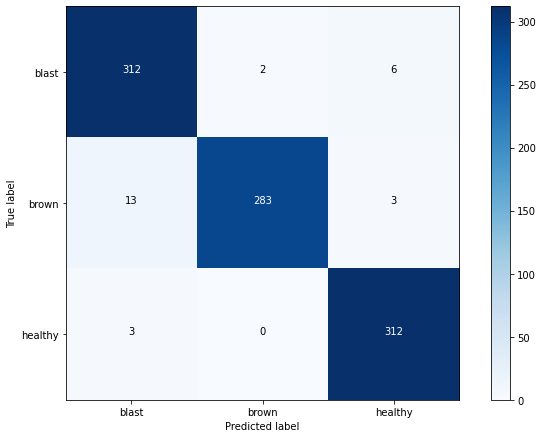

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, convnext_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_convnext_tiny_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999914,0.000003,0.000083
1,id_01hu05mtch.jpg,0.003184,0.996790,0.000026
2,id_030ln10ewn.jpg,0.951352,0.002822,0.045826
3,id_03z57m8xht.jpg,0.999964,0.000010,0.000026
4,id_04ngep1w4b.jpg,0.995109,0.000431,0.004460


score : 0.24

# ConvNext Small

In [13]:
m = models.convnext_small(weights=models.ConvNeXt_Small_Weights.DEFAULT)
print(m)

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate=none)
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96

In [14]:
class myConvNextSmall(nn.Module):
  def __init__(self, num_classes):
    super(myConvNextSmall, self).__init__()
    self.model_ft = models.convnext_small(weights=models.ConvNeXt_Small_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.classifier[2].in_features
    self.model_ft.classifier[2] = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [15]:
convnext_small_tf = myConvNextSmall(3)

In [26]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=50, aug_transform=aug_transform1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(convnext_small_tf.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "convnext_small_aug_checkpoint.pt"))

In [25]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [27]:
convnext_small_tf, val_label, val_pred = train_model(device, convnext_small_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.6596 Acc: 0.7160
val Loss: 0.5345 Acc: 0.8137
Validation loss decreased (inf --> 0.534486).  Saving model ...
Epoch 2/30
----------
train Loss: 0.2387 Acc: 0.9145
val Loss: 0.3409 Acc: 0.8865
Validation loss decreased (0.534486 --> 0.340916).  Saving model ...
Epoch 3/30
----------
train Loss: 0.1291 Acc: 0.9574
val Loss: 0.1748 Acc: 0.9540
Validation loss decreased (0.340916 --> 0.174765).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0845 Acc: 0.9695
val Loss: 0.2212 Acc: 0.9443
EarlyStopping counter: 1 out of 5
Epoch 5/30
----------
train Loss: 0.0377 Acc: 0.9877
val Loss: 0.1300 Acc: 0.9690
Validation loss decreased (0.174765 --> 0.129981).  Saving model ...
Epoch 6/30
----------
train Loss: 0.0416 Acc: 0.9853
val Loss: 0.3142 Acc: 0.9218
EarlyStopping counter: 1 out of 5
Epoch 7/30
----------
train Loss: 0.0558 Acc: 0.9820
val Loss: 0.1372 Acc: 0.9615
EarlyStopping counter: 2 out of 5
Epoch 8/30
----------
train Loss: 0.0217 Acc: 0.9928


In [28]:
test_pred = test_model(device, convnext_small_tf, test_loader)

In [29]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_convnext_small_aug.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999967,0.000031,0.000001
1,id_01hu05mtch.jpg,0.001850,0.998149,0.000001
2,id_030ln10ewn.jpg,0.997530,0.002414,0.000057
3,id_03z57m8xht.jpg,0.999982,0.000016,0.000002
4,id_04ngep1w4b.jpg,0.999533,0.000459,0.000008


score : 0.31